This notebook will provide examples of using differing kriging parameters to achieve different goals.

A copper deposit is used, applying data available in two different phases: i) interim estimation with sparse exploration drillhole data for the purpose of global resources, ii) final estimation with dense blasthole data for the purpose of local ore/waste definition. The notebook steps are enumerate, noting the three kriging goals from the lesson:

1. **Load and Visualize Data**
    - Load example drillhole and blasthole data, then visualize spatial variability.

2. **Variography, Including Kriging for Trends**
    - For drillhole data at the exploration phase, krige a neutral model to determine principal directions of anisotropy from underlying grade trends; variograms are then calculated and fit along these principal directions
    - For blasthole data, calculate experimental variograms along a variogram sphere (40 equal spaced directions), before autofitting a model that optimizes the angles/ranges to respect all directions simultaneously

4. **Kriging for Interim Estimates**
    - Calculate a discrete Gaussian model (DGM) to define the target distribution of estimation, considering mining selectivity and information effect
    - Demonstrate the calibration of kriging parameters with drillhole data to match the DGM, while considering other secondary priorities such as conditional bias

5. **Kriging for Final Estimates**
    - Calibrate kriging of blasthole data to minimize conditional bias of the estimate, while considering other secondary priorities such as estimate variance
    
6. **Closing Comments**

The presented workflow may be extended to represent other deposits. Inline annotations with each step will note practical adjustments that may be necessary for this extension.

---

Import required packages:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rmsp; rmsp.activate()  # See: https://resourcemodelingsolutions.com/rmsp

License cleq45ynp00hggomxzudtanh0 checked out by cleq3u00o0001mxb8e7xapuw4 to cleu6f8al000bs23fjbek6ljd expires in 8 minutes. RMSP is up to date!


Set a couple of global settings:

In [2]:
rmsp.GlobalParams['core.enable_beta'] = True
rmsp.GlobalParams['spatial.unit'] = 'ft'
rmsp.GlobalParams['plotting.viewer3d.render_points_as_spheres'] = True
# Comment this line to use the interactive viewer instead
rmsp.GlobalParams['plotting.viewer3d.show_static'] = True

---
# Load and Visualize Data

Load the example drillhole data, which we will use primarily for interim estimates:

In [3]:
dh = rmsp.load_example_data("ccg_dh")
dh.head()

dh  from    to           x           y         z       Au       Cu  \
0   1   0.0  10.0  19975.1709  18698.0376  210.0856  0.07813  50.0000   
1   1  10.0  20.0  19978.1547  18702.6831  201.7479  0.09100  33.0000   
2   1  20.0  30.0  19981.1466  18707.3233  193.4103  0.98800  97.0001   
3   1  30.0  40.0  19984.1556  18711.9612  185.0775  0.36400  66.0000   
4   1  40.0  50.0  19987.1566  18716.5869  176.7350  0.48100  58.0000   

   Au:shell  Cu:shell       startx       starty     startz         endx  \
0         0         0  19972.18710  18693.39210  218.42330  19976.66280   
1         0         0  19976.66280  18700.36035  205.91675  19979.65065   
2         0         0  19979.65065  18705.00320  197.57910  19982.65110   
3         0         0  19982.65110  18709.64225  189.24390  19985.65610   
4         0         0  19985.65610  18714.27405  180.90625  19988.65800   

          endy       endz  
0  18700.36035  205.91675  
1  18705.00320  197.57910  
2  18709.64225  189.24390  
3  18714.27405  180.90625  
4  18718.91325  172.57160

Load the example blasthole data, which we will use primarily for final ore control estimates:

In [4]:
bh = rmsp.load_example_data("ccg_bh")
bh.head()

bhid            x            y      z    Au   Ag    Cu  Geol
0  211447  20073.71245  18523.96088  290.1  0.03  7.4  73.0   223
1  211448  20065.73519  18520.00900  290.0  0.01  4.2  57.0   223
2  211449  20071.70121  18519.08275  290.1  0.05  3.8  68.0   223
3  211450  20069.21163  18514.10732  290.0  0.02  2.0  48.0   223
4  211451  20067.93279  18524.86269  290.0  0.03  6.2  75.0   223

We will focus on copper throughout this demonstration. Setup standard coloring:

In [5]:
var = rmsp.Variable("Cu").set_variable_params(
    clim=(20, 375), cmap='Spectral_r')

Initialize grids. Interim (drillhole) estimation will be done on $20x15x10 ft$ foot blocks, whereas final (Blasthole) estimation will be done on $(5 ft)^3$ blocks

In [6]:
int_grid = rmsp.GridData.from_scattered_points(
    bh, 20, 20, 10, srch_radius=30)
fin_grid = int_grid.change_cell_size(5, 5, 5)

Visualize the datasets and grid with respect to each other:

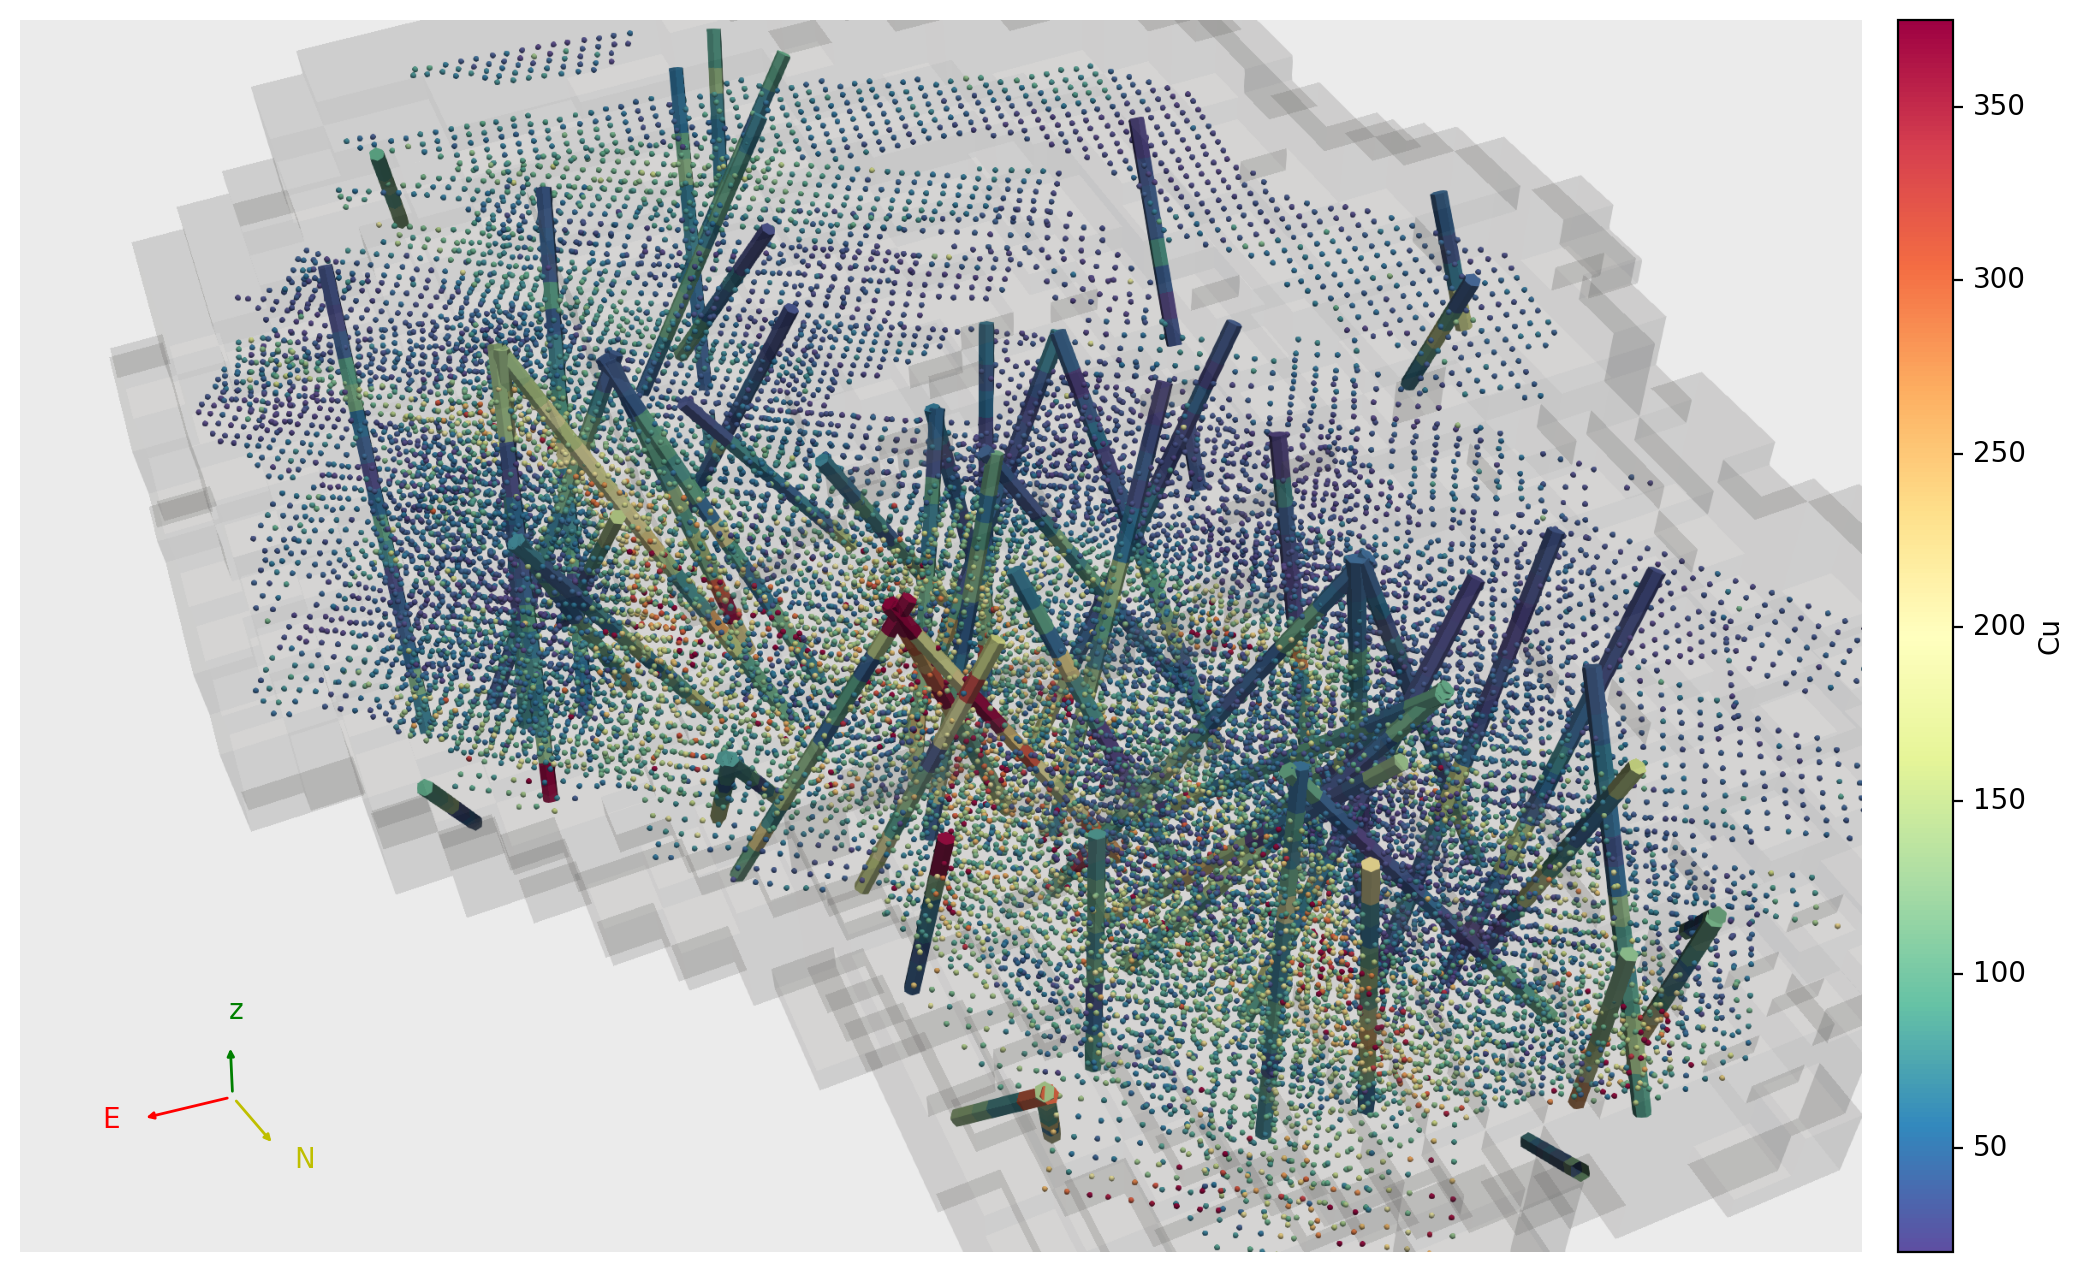

In [7]:
viewer = bh.view3d(var.col, point_size=7)
viewer = dh.view3d(var.col, representation='Surface', viewer=viewer)
fin_grid.view3d(color='.5', alpha=.1, viewer=viewer)
view_matrix = [20190.96,19303.98,754.00,20001.46,18752.81,167.56,-0.30,-0.64,0.70]  # use throughout for other visualizations
viewer.set_camera(view_matrix=view_matrix)

---
# Variography, Including Kriging for Trends

Before performing kriging with the drillholes and blastholes, input variogram models are required for each dataset. Note that this includes the first use of estimation described in the Lesson, where a smooth neutral model is generated for determining principal directions of continuity (e.g., based on generating a smooth trend estimate).

## Drillhole Variogram

### Nugget Effect

Use an omnidirectional variogram to inform the isotropic nugget effect. Begin by calculating the experimental variogram:

In [8]:
lags = [rmsp.Lags(6, 3, 12), rmsp.Lags(10, 5, 5)]
search = rmsp.ExpVarioSearch(0, 0, lags, azmtol=90, incltol=90)
expvario = rmsp.ExpVario("pairwiserel").calculate(dh, var, search)

Fit the experimental variogram with a variogram model. This model is not input to kriging, but is used for parameterizing the nugget effect and visualizing if the shape (exponential here) is reasonable at the critical short scale. These two parameters will be exteneded to the final directional variograms.

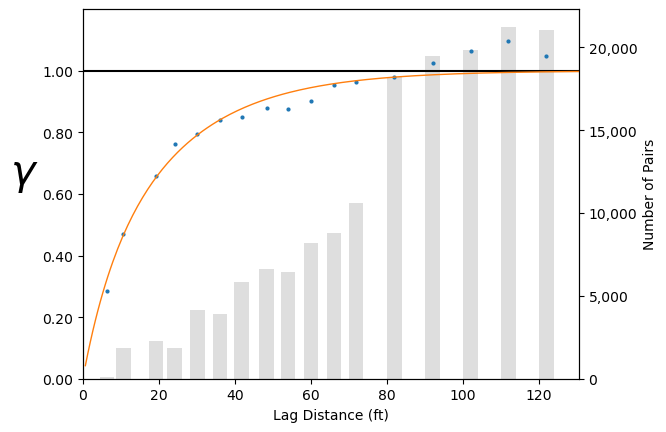

In [9]:
shapes = "exponential"
variomod = rmsp.VarioModel.fit_experimental(
    expvario,
    shapes=shapes,
    num_struct=2,
    ranges12_bounds=1,
    ranges13_bounds=1,
)
fig, ax = expvario.plot(pairs_bar=True)
variomod.plot_draw(ax)

Nugget effect above looks reasonable, so extract for use in directional fitting:

In [10]:
nugget = np.round(variomod.nugget, 2)
nugget

0.0

### Determine principal directions using a kriged neutral model

As the exploration data is relatively sparse, the following workflow is used for determining the main directions of continuity:

1. Calculate a neutral model, where a large nugget and isotropic ranges smooth through data variability to reveal underlying continuity trends
2. Calculate a variogram volume on the neutral model values
3. Fit a variogram model to the variogram volume to auto-fit the principal directions of continuity

Note that this workflow is only used for determining the principal directions, as the variogram model is fit to a variogram volume (and underlying neutral model) with greater continuity than the variable we are modeling. The next sub-section calculates experimental variograms along these principal directions.

In [11]:
neutralmod = int_grid.change_cell_size(10, 10, 10)

Define an isotropic variogram with relatively high nugget and then estimate onto a fine grid. This will serve to filter out short scale noise and should only preserve large-scale structural trends in the data.

In [12]:
neutralvario = rmsp.VarioModel(
    vario_str="""1    0.40 -nst, nugget effect
    1    0.60  0.0   0.0   0.0        -it,cc,ang1,ang2,ang3
          180.0  180.0  180.0        -a_hmax, a_hmin, a_vert"""
)

krige = rmsp.KrigeEstimator("dual", neutralvario)
neutralmod[var] = krige.estimate(neutralmod, dh, var.col)

Visualize the estimates using a neutral model:

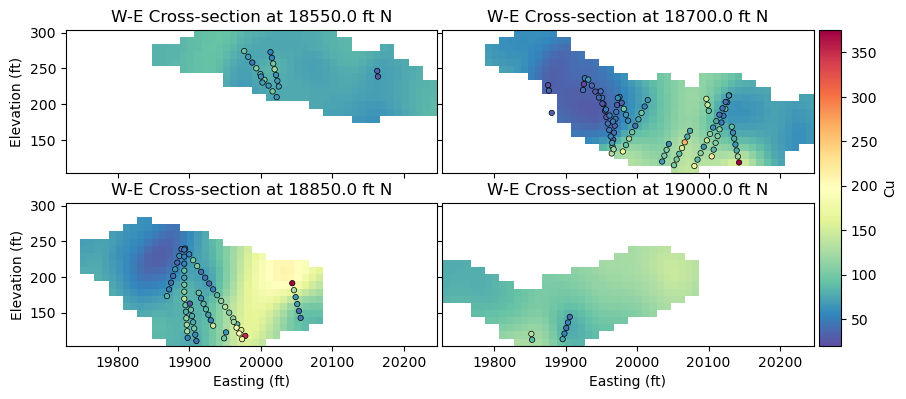

In [13]:
scene = dict(coordinates=[18550, 18700, 18850, 19000], orient='xz', )
fig, axes = neutralmod.sectionplots(var, **scene)
_ = dh.sectionplots_draw(axes, var.col, **scene, tolerances=20, s=15, ec='k')

Calculate and experimental variogram volume and fit a variogram

In [14]:
neutralexp = rmsp.ExpVario().calculate_volume(
    neutralmod.to_pointdata(),
    var,
    rmsp.ExpVarioVolume([10, 10, 10], [10, 10, 10]),
)

variomod = rmsp.VarioModel.fit_experimental(
    neutralexp,
    num_struct=2,
    shapes='exponential',
    range1=[[1, 500]] * 2,
    ranges12_bounds=[[1, 10]] * 2,
    ranges13_bounds=[[1, 10]] * 2,
)

Visualize the fit variogram. Remember that only the anisotropy directions should be assessed at this stage, the scale/ranges shown here are purely for visualization and will be fit properly later.

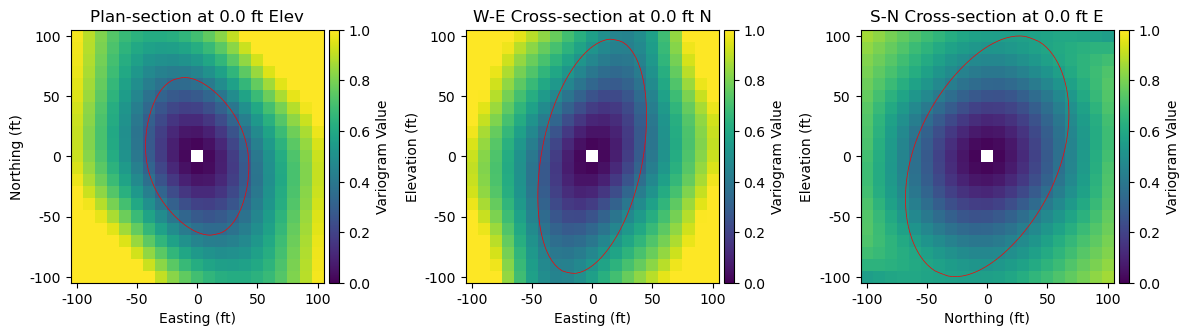

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, orient in zip(axes, ["xy", "xz", "yz"]):
    neutralexp.sectionplot(ax=ax, orient=orient)
    variomod.sectionplot_draw(ax, vario_value=0.5, color='r', orient=orient)
fig.tight_layout()

Extract principal directions:

In [16]:
principals = variomod.get_principals()
print("principal directions for experimental calculation:\n", principals)
major_angles = {
    f"angle{i + 1}": a for i, a in enumerate(variomod.get_dict()['angles'][0])
}
print("major angles for model fitting:\n", major_angles)

principal directions for experimental calculation:
 [{'azm': 23.784187085917125, 'incl': 70.14917085548143}, {'azm': 161.70774902672449, 'incl': 15.001167969711812}, {'azm': 255.16917304207732, 'incl': 12.697277692366507}]
major angles for model fitting:
 {'angle1': 23.78418708591712, 'angle2': 70.14917085548143, 'angle3': -49.66285622751508}


### Directional variogram calculation and fitting

Using the above principal directions, calculate experimental variograms for the purpose of calculating variogram ranges and structures

In [17]:
searches = [
    rmsp.ExpVarioSearch(
        p["azm"],
        p["incl"],
        [rmsp.Lags(10.0, 7.5, 10),rmsp.Lags(20.0, 15.0, 4)],
        azmtol=30,
        incltol=30,
    )
    for p in principals[:2]
]
searches += [
    rmsp.ExpVarioSearch(p["azm"], p["incl"], lags, azmtol=50, incltol=50)
    for p in principals[2:]
]
expvario = rmsp.ExpVario("pairwiserel").calculate(dh, var, searches)

Fit the experimental variogram with a variogram model, which will be input to kriging below

Nugget  Structure 1  Structure 2
Contribution  0.000        0.404        0.596
Model Shape          exponential  exponential
Angle 1                     23.8         23.8
Angle 2                     70.1         70.1
Angle 3                    -49.7        -49.7
Range 1                     20.4        140.6
Range 2                     20.4        138.2
Range 3                     20.4         62.5

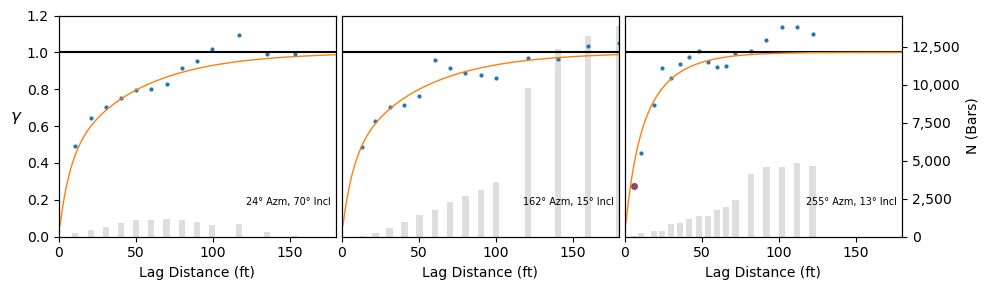

In [18]:
num_struct = 2
dh_variomod = rmsp.VarioModel.fit_experimental(
    expvario,
    nugget=nugget,
    shapes=shapes,
    num_struct=num_struct,
    ranges12_bounds=[[0.8, 10]] * num_struct,
    range3=[[20, 200]] * num_struct,
    order_ranges=True,
    sort_by_range1=True,
    **major_angles
)

fig, axes = expvario.gridplot(figsize=(10, 3), model=dh_variomod, pairs_bar=True)
dh_variomod.to_table()

Visualize the variogram with respect to the drillholes 

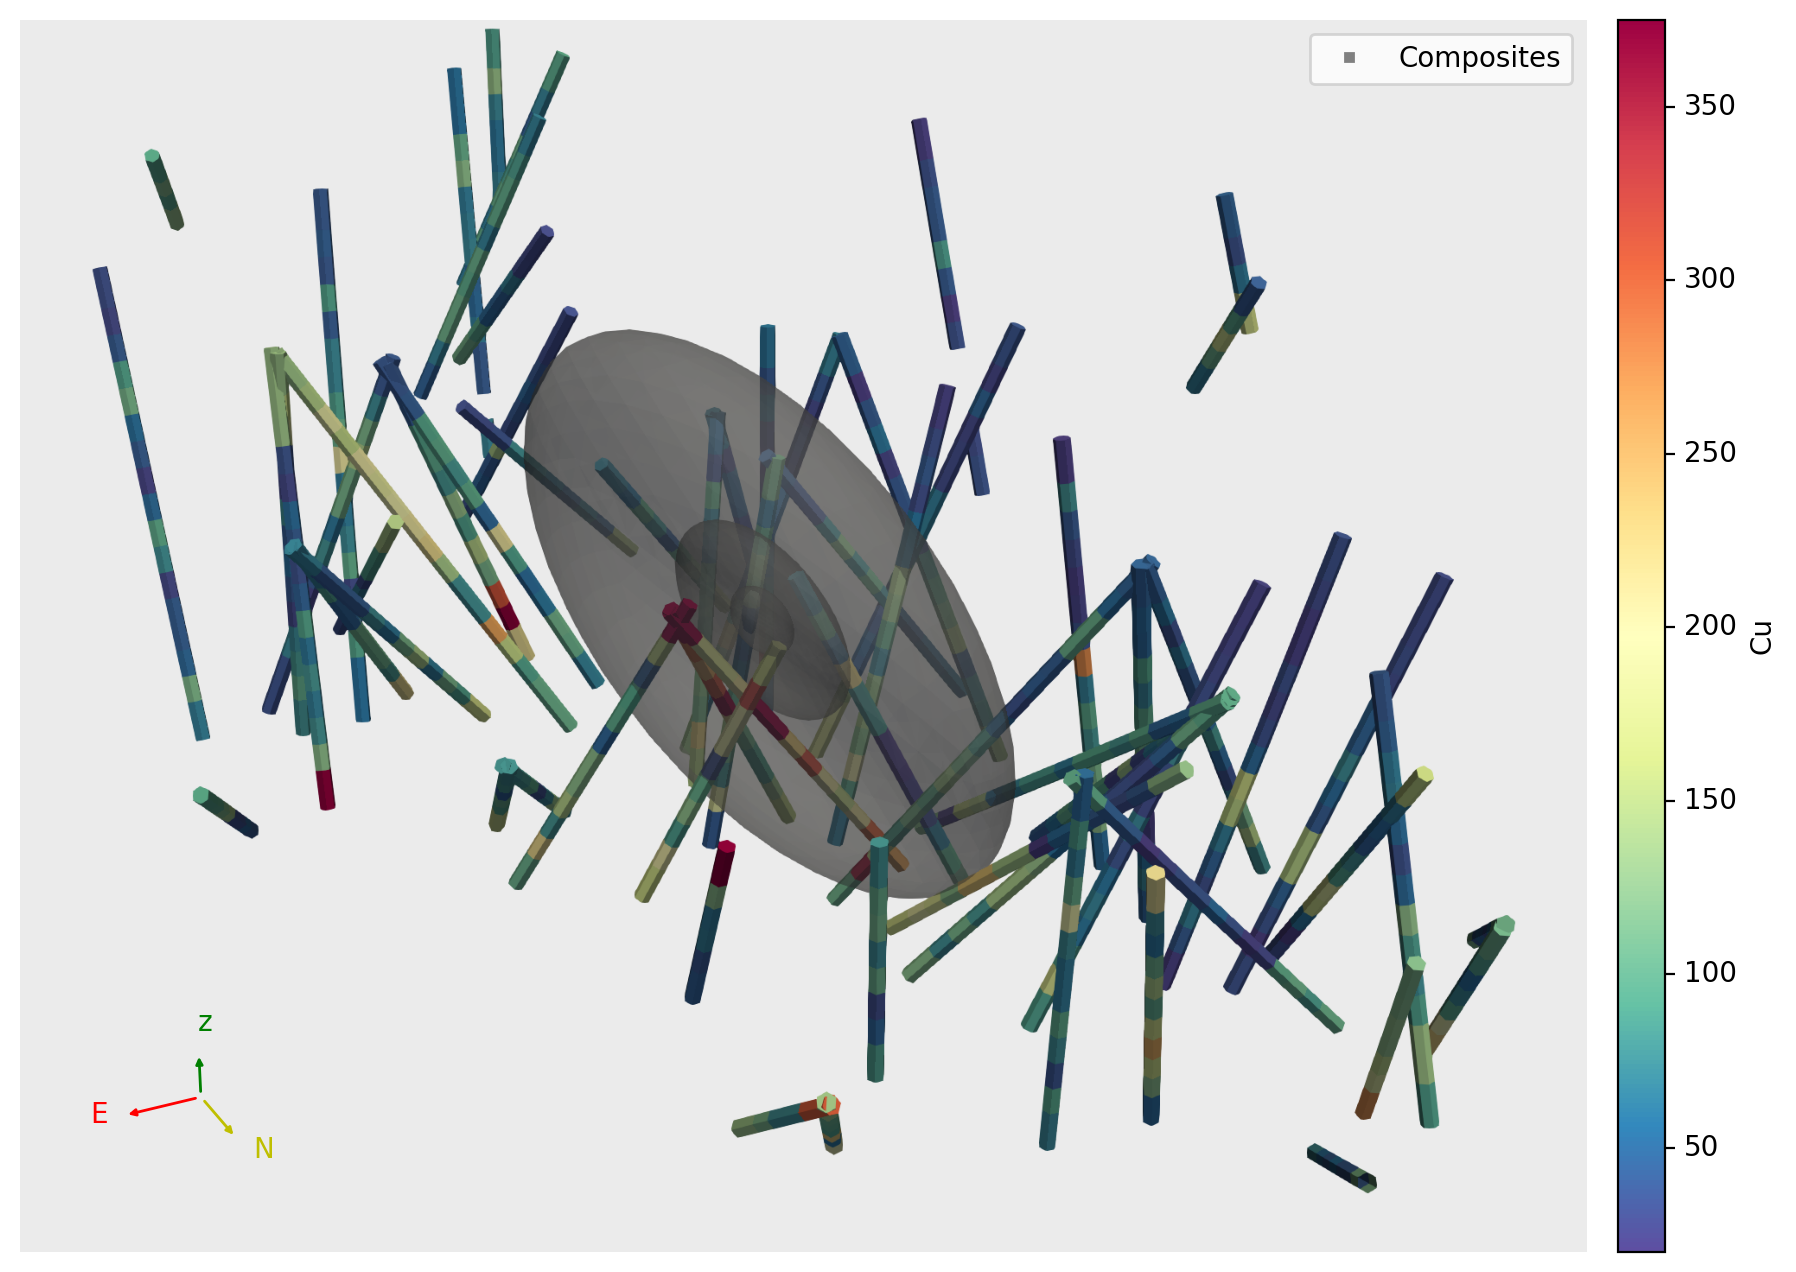

In [19]:
viewer = dh.view3d(var.col, representation="Surface", label="Composites")
viewer.set_camera(view_matrix=[20124.49,19267.81,1132.29,20001.46,18752.81,167.56,-0.35,-0.81,0.48])
for v in [0.5, 0.75, 0.95]:
    dh_variomod.to_solid(buffer_at=v, origin=dh.spatial_centroid).view3d(
        viewer=viewer, alpha=0.5, color=".5"
    )
viewer.set_camera(view_matrix=view_matrix)

## Blasthole Variogram

### Nugget Effect

Use an omnidirectional variogram to inform the isotropic nugget effect. Begin by calculating the experimental variogram:

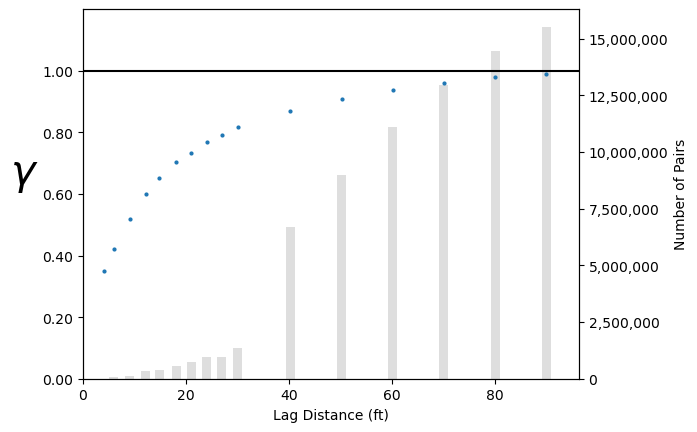

In [20]:
lags = [rmsp.Lags(3, 1.5, 10), rmsp.Lags(10, 5, 6)]
search = rmsp.ExpVarioSearch(0, 0, lags, azmtol=90, incltol=90)
bh_expvario = rmsp.ExpVario("pairwiserel").calculate(bh, var, search)
_ = bh_expvario.plot(pairs_bar=True)

Fit the experimental variogram with a variogram model. This model is not input to kriging, but is used for parameterizing the nugget effect and visualizing if the shape (exponential here) is reasonable at the critical short scale. These two parameters will be exteneded to the final directional variograms.

Nugget  Structure 1  Structure 2  Structure 3
Contribution  0.050        0.465        0.352        0.133
Model Shape          exponential  exponential  exponential
Angle 1                      0.0          0.0          0.0
Angle 2                      0.0          0.0          0.0
Angle 3                      0.0          0.0          0.0
Range 1                     82.9         14.8         62.9
Range 2                     14.6         40.8        153.4
Range 3                     15.3         84.2        120.2

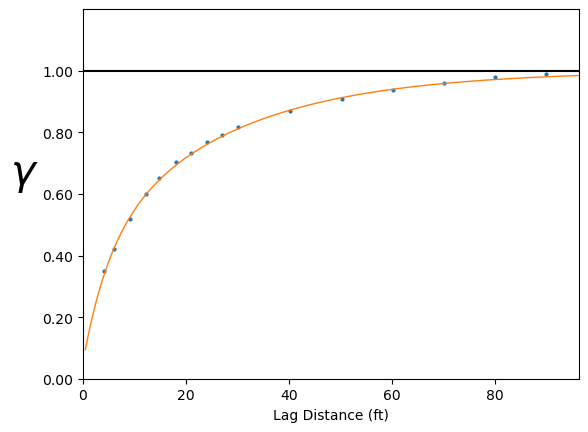

In [21]:
shapes = "exponential"
bh_variomod = rmsp.VarioModel.fit_experimental(
    bh_expvario,
    shapes=shapes,
    nugget=[0.0, 0.05]
)
fig, ax = bh_expvario.plot()
bh_variomod.plot_draw(ax)
bh_variomod.to_table()

Nugget effect above looks reasonable, so extract for use in directional fitting:

In [22]:
bh_nugget = np.round(bh_variomod.nugget, 2)
bh_nugget

0.05

### Variogram Sphere

Since the blasthole data was collected at such a high density, a variogram can be fit by calculating experimental variograms in many directions simultaneously and then finding the variogram model direction/anisotropy that provides the best fit.

Nugget  Structure 1  Structure 2
Contribution  0.050        0.748        0.202
Model Shape          exponential  exponential
Angle 1                    147.5        147.5
Angle 2                     13.2         13.2
Angle 3                    -21.3        -21.3
Range 1                     51.5        531.0
Range 2                     34.3         92.9
Range 3                     32.2         92.9

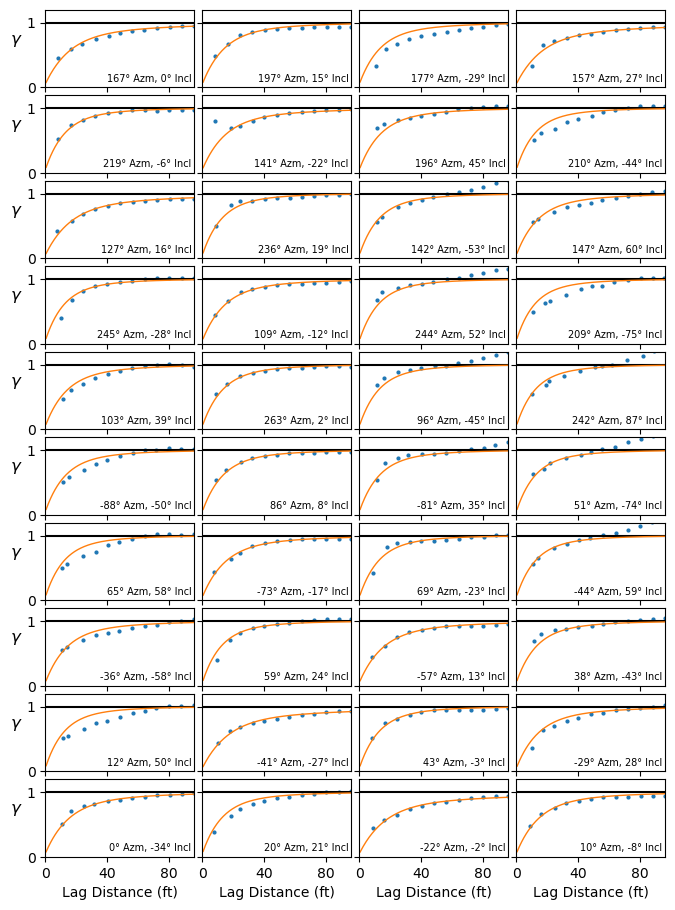

In [23]:
lags = rmsp.Lags(8, 4.0, 12)
searches = rmsp.ExpVarioSearch.sphere(lags)
bh_expvario = rmsp.ExpVario("pairwiserel").calculate(bh, var, searches)

num_struct = 2
bh_variomod = rmsp.VarioModel.fit_experimental(
    bh_expvario,
    nugget=bh_nugget,
    shapes=['exponential'] * num_struct,
    num_struct=num_struct,
    ranges12_bounds=[[1.0, 10]] * num_struct,
    ranges13_bounds=[[1.0, 10]] * num_struct,
    order_ranges=True,
    sort_by_range1=True
)
fig, axes = bh_expvario.gridplot(model=bh_variomod)
bh_variomod.to_table()

Visualize variogram anisotropy against the data. Although the anisotropy is a reasonable representation of the overall deposit, note that locally varying anisotropy could make sense in practice here.

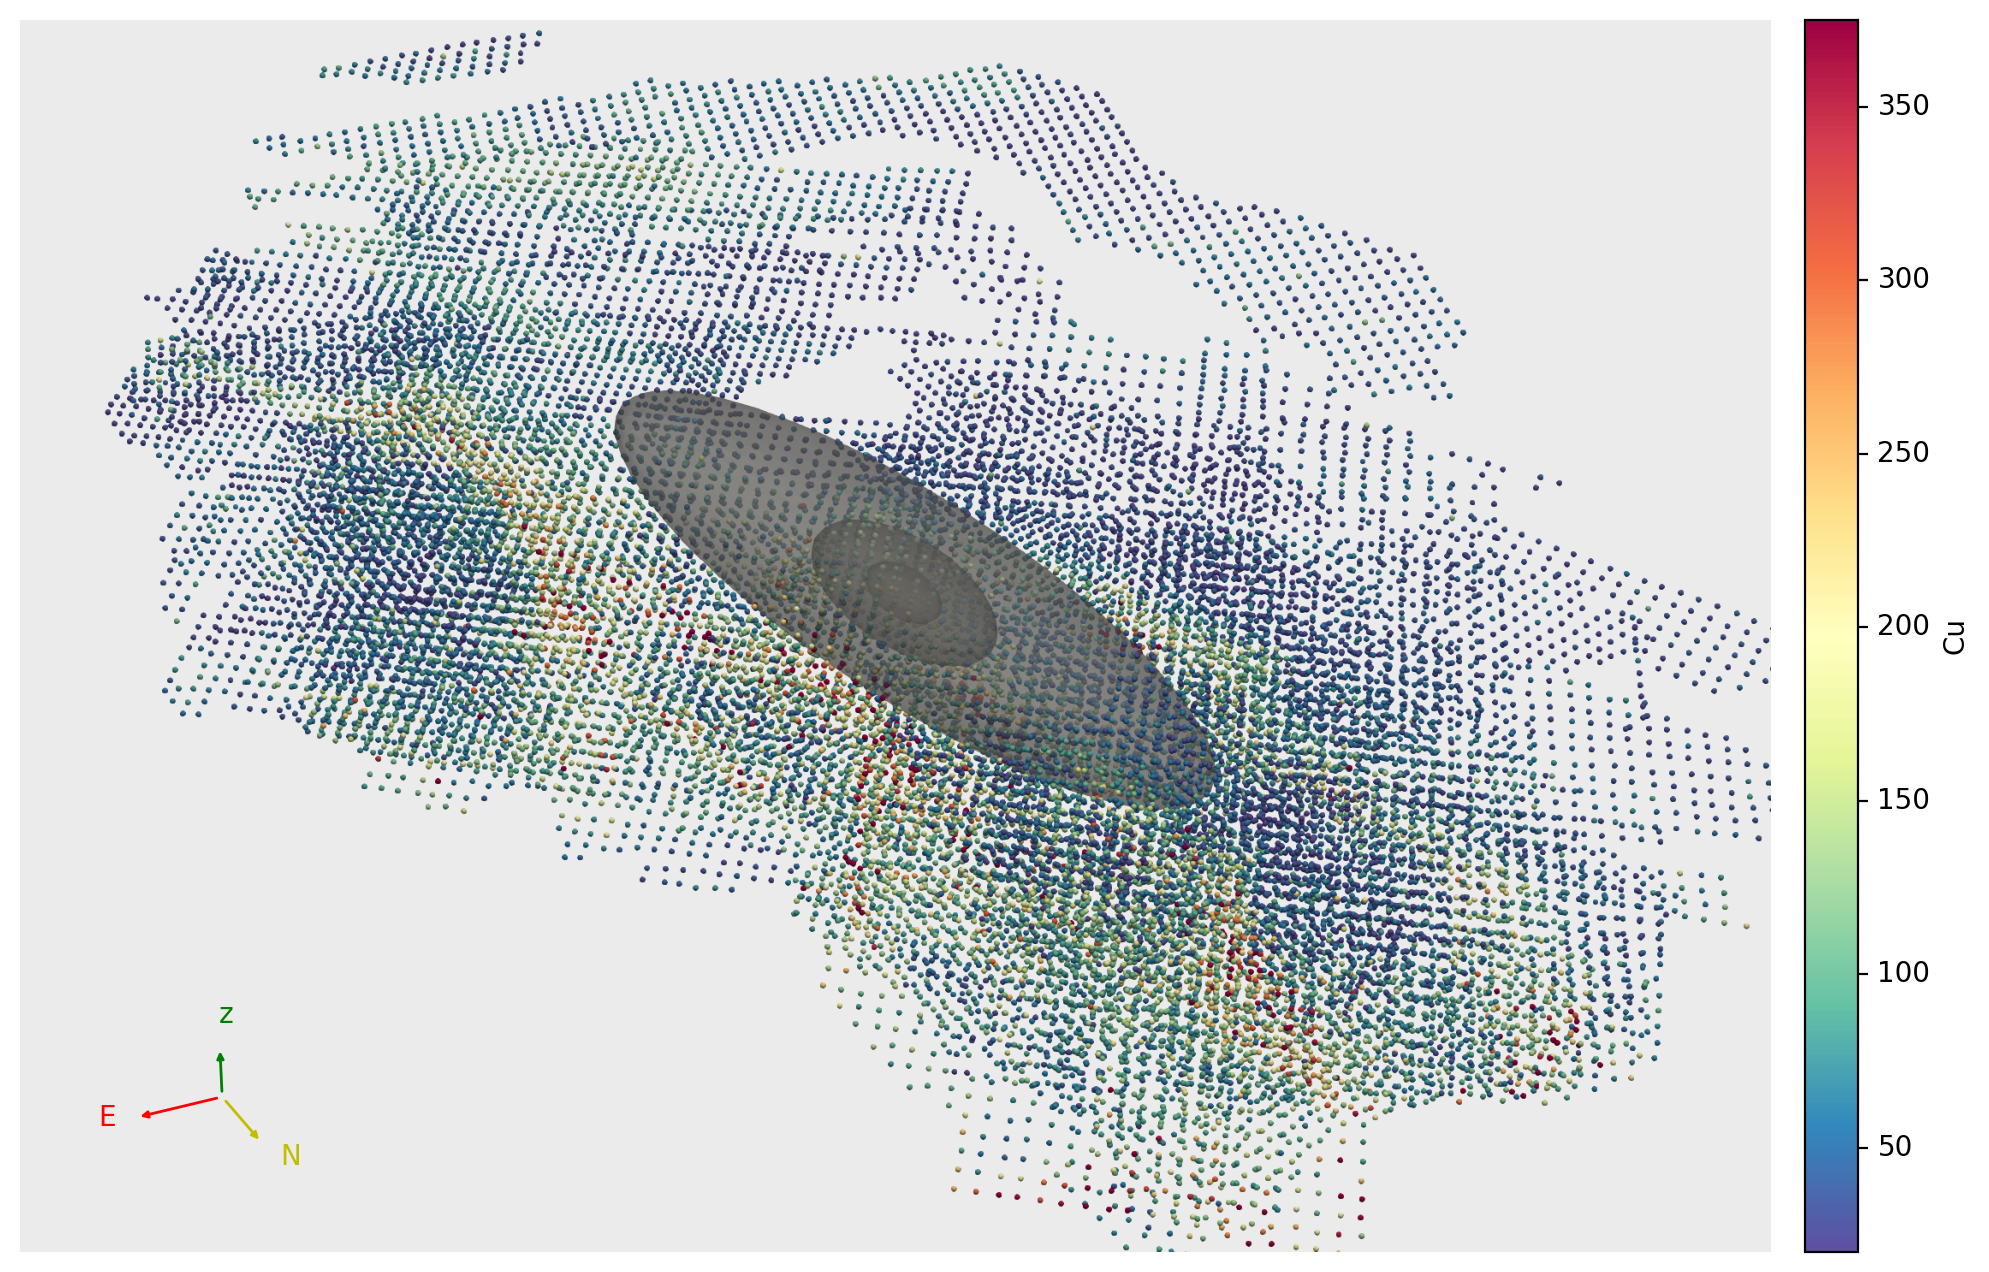

In [24]:
viewer = bh.view3d(var.col, point_size=7)
for v in [0.5, 0.75, 0.9]:
    bh_variomod.to_solid(buffer_at=v, origin=bh.spatial_centroid).view3d(
        viewer=viewer, alpha=0.5, color=".5"
    )
viewer.set_camera(view_matrix=view_matrix)

---
# Kriging For Interim Estimates

Utilizing the exploration drillhole data and associated variogram model from the prior section, interim estimation is performed using calibration to match targeted change of support. Conditional bias is inspected simultaneously for understanding, but is not prioritized at this phase.

## Declustering

Perform declustering to assemble the representative point scale distribution, which will scale to the SMU support in the next step. Inverse distance declustering is used, applying a search that has its anisotropy based on the variogram model range:

In [25]:
search = rmsp.Search.from_vario_buffer(dh_variomod, buffer_by=4, min_comps=4, max_comps=12)
id2 = rmsp.IDWEstimator(search, 2)
dh['wt'] = rmsp.DeclusterEstimator(id2).decluster(int_grid, dh, var.col)
search

Search Parameters:
Angle 1      23.8
Angle 2      70.1
Angle 3     -49.7
Range 1     335.0
Range 2     329.1
Range 3     150.3
Min. Comps      4
Max. Comps     12

Visualize the declustering weights with respect to the model volume and search anisotropy:

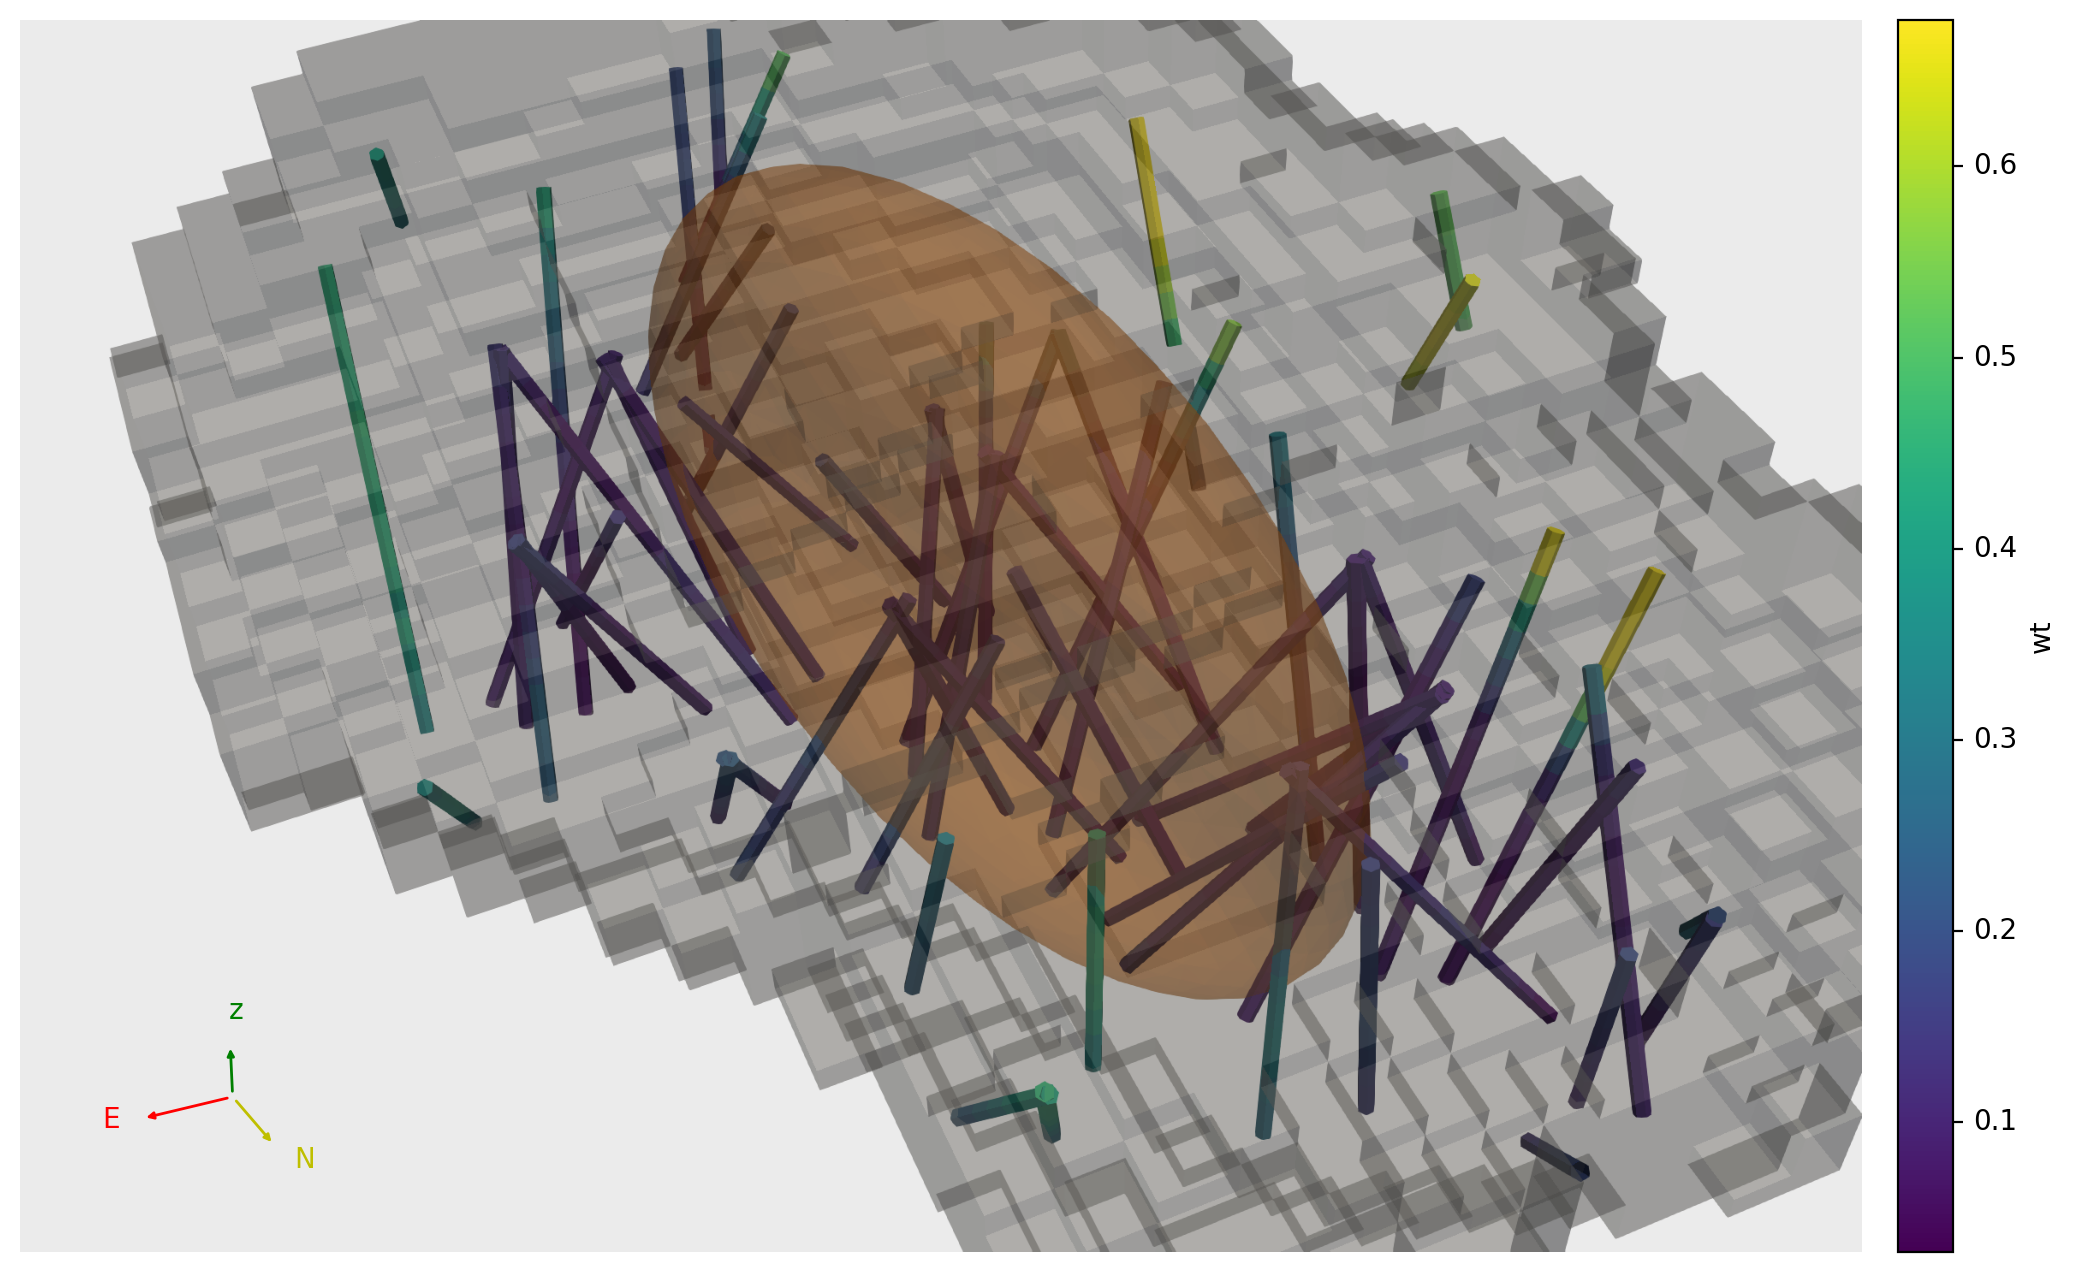

In [26]:
viewer = int_grid.view3d(color='.5', alpha=0.3)
dh.view3d('wt', representation='Surface', viewer=viewer)
search.view3d(scale=.5, origin=int_grid.spatial_centroid, viewer=viewer, alpha=0.4)
viewer.set_camera(view_matrix=view_matrix)

## Calibration using DGM

Using the variogram, calculate the average variogram value within a 25 foot block (SMU) in order to calculate the expected variance at that scale

gammabar=0.49, f_coeff=0.51


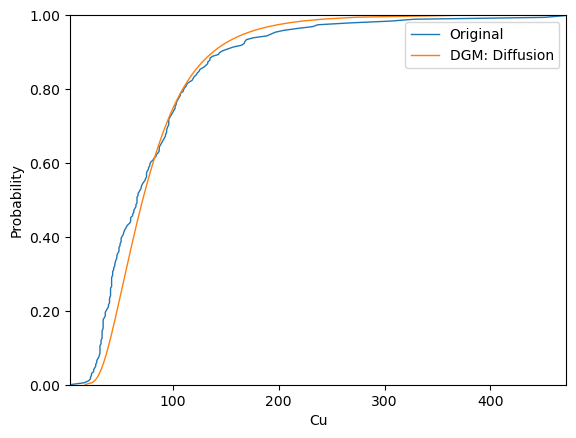

In [27]:
gammabar, f_coeff = dh_variomod.get_gammabar(int_grid.griddef.blocksize, [5, 5, 5])

histscale = rmsp.HistScale('dgm_diff', f_coeff=f_coeff)
histscale.scale_histogram(dh[var], dh['wt'])
histscale.cdfplot_overlap()
print(f'gammabar={gammabar:.2f}, f_coeff={f_coeff:.2f}')

Set up test estimators that use an increasing number of min/max composites, also testing two and three maximum composites per drillhole:

In [28]:
estimators = [
    rmsp.KrigeEstimator(
        rmsp.Search.from_vario_buffer(
            dh_variomod,
            buffer_by=4,
            min_comps=max_comps,
            max_comps=max_comps,
            max_comps_per_dhid=max_comps_per_dhid,
        ),
        dh_variomod,
        constraints=(0, None),
        num_discret=[3, 3, 3],
    )
    for max_comps in [6, 8, 10, 12]
    for max_comps_per_dhid in [2, 3]
]

Evaluate each of the test estimators above in two different modes:
- Gridded estimation, used for assessing metrics such as block estimation variance and contained metal. The smaller the deviation from the input DGM (or other reference model), the better. The contained metal is based on a specified `cutoff`, where underlying ore tonnage or grade-above-cutoff could also be evaluated.
- Leave-one-out-cross-validation (LOOCV) where each individual drillhole is iteratively removed, before estimating with the remaining holes at that location. The removed test values may be compared against the estimated values, allowing for local accuracy (e.g., RMSE) and conditional bias (e.g., slope of regression or SOR) to be assessed. The smaller the RMSE and closer the SOR to 1, the better.

Note that in interim estimation, we are primarily concerned with matching the DGM in terms of block variance or contained metal at particular cutoff(s). These two metrics are equally weighted in selecting the best estimator, through their specification as `metric`. The LOOCV statistics will be inspected for reference, but will be more directly prioritized when performing final estimates (next section).

In [29]:
cutoff = 115
calibrator = rmsp.EstCalibrator(
    estimators,
    f_coeff=f_coeff,
    cutoffs=cutoff
).run_scenarios(
    int_grid,
    dh,
    var.col,
    'wt',
    progressbar=True,
    metric=['blkvar', 'metal0']
)

Inspect the calibration results. Observe that Scenario 1 provides the smallest block variance deviation (%Var. Dev.) and metal deviation (%Metal Dev.) of the estimates relative to the DGM, and is therefore selected as the optimal estimator.

In [30]:
calibrator.to_table(
    params=[
        "max_comps",
        "max_comps_per_dhid"
    ],
    stats=['blkvar', 'metal0', 'rmse', 'sor'],
)

Although summarized by statistics in the table above, perform a closer inspection of the estimation/DGM distribution matching using CDF plots and GT-curves (again, highlighting the optimal estimate scenario):

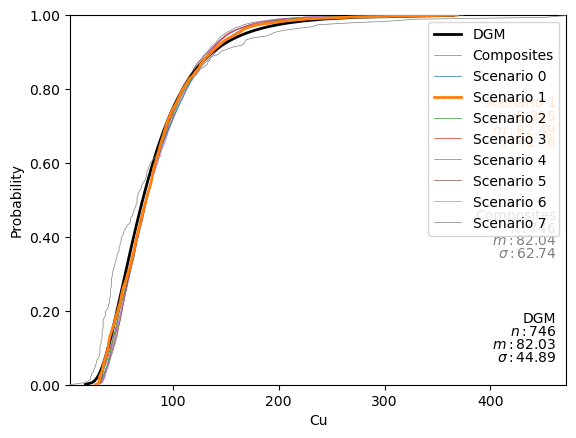

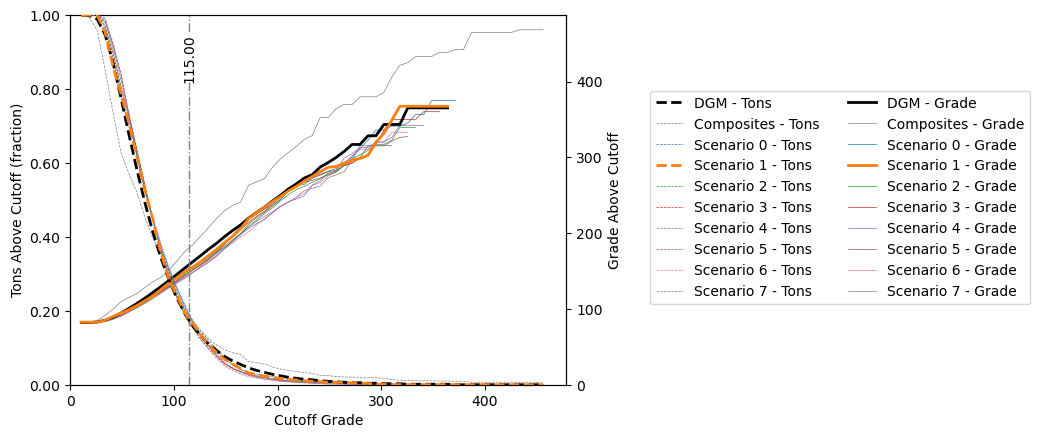

In [31]:
calibrator.cdfplot()
_ = calibrator.plot_grade_tonnage_curve()

## Gridded estimation using optimal estimator

Grab the optimal estimator and note that its search corresponds with the highlighted results above:

In [32]:
estimator = calibrator.get_estimator()
estimator.search

Search Parameters:
Angle 1              23.8
Angle 2              70.1
Angle 3             -49.7
Range 1             335.0
Range 2             329.1
Range 3             150.3
Min. Comps              6
Max. Comps              6
Max. Per Drillhole      3

Estimate across the grid, returning the gridded estimate as well as other common metrics of permformance:

In [33]:
int_grid = estimator.estimate(int_grid, dh, var.col,
                              output=['estimate', 'efficiency', 'slope_of_reg'])

Visualize the results. Note that some artifacts (e.g., patchiness) is present due to the restricted search. These artifacts are expected and associated with conditional bias, but are often acceptable for interim estimation since global resource accuracy is being prioritized. The next section features estimation for final ore control modeling, where local accuracy (minimizing conditional bias) is prioritized, and a comparatively smooth/artifact free result is shown.

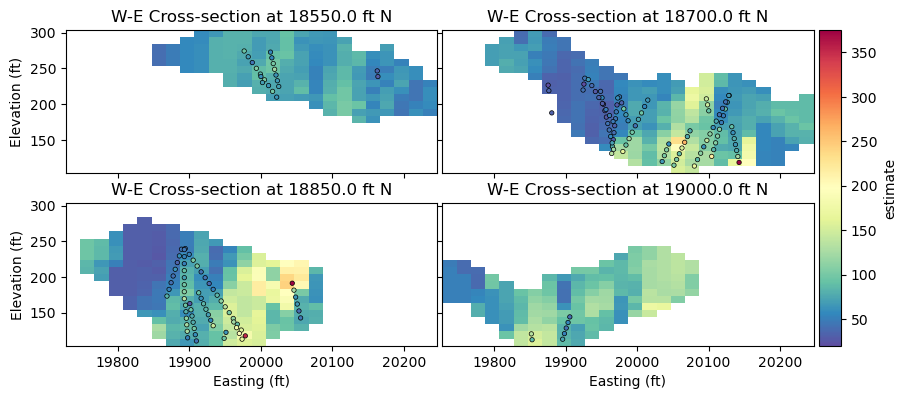

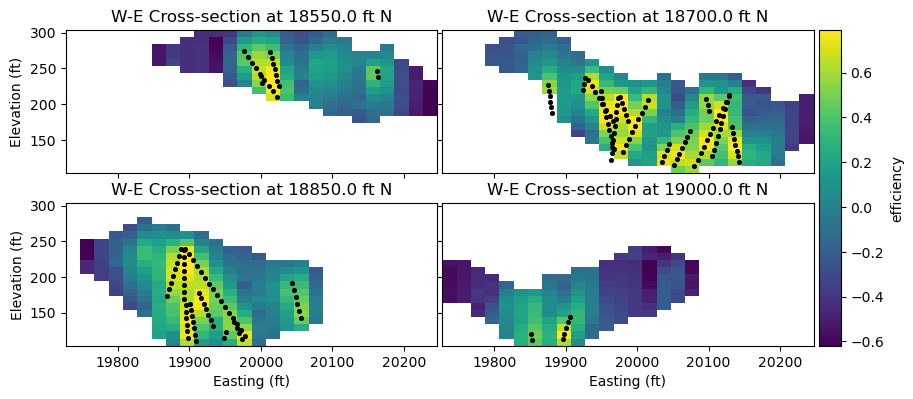

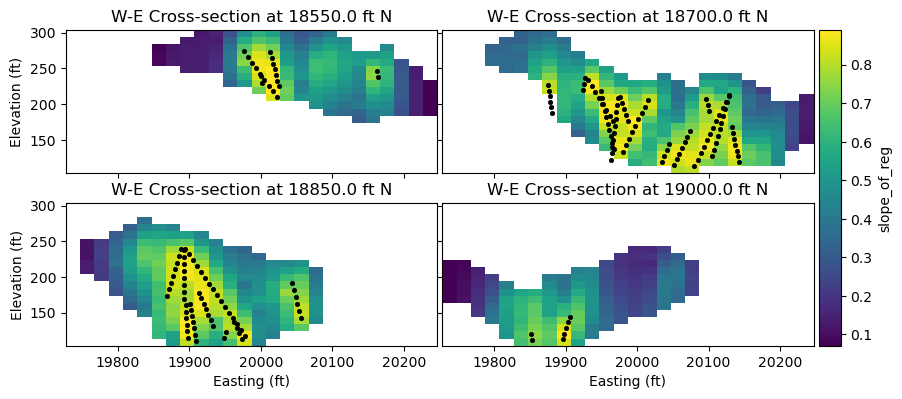

In [34]:
var.clone('estimate')  # use the same color scheme/limits as Cu var
for col in int_grid.columns:
    fig, axes = int_grid.sectionplots(col, **scene)
    _ = dh.sectionplots_draw(axes, var.col if col=='estimate' else 'k',
                             **scene, tolerances=20, s=10, ec='k')

---

# Kriging for Final Estimates

Utilizing the BH data and associated variogram model, estimation to inform final ore control (ore/waste delineation) is performed. Change of support is considered, but minimization of conditional bias and local error is prioritized.

## Calibration (assess local accuracy vs. variance)



Through assigning a particular `cutoff` value (defined in the prior section), the additional metrics of Type I and Type II errors can be calculated (as well as ore tonnage, grade and contained metal previously shown). These utilize LOOCV as described above and identify how frequently the estimator is mischaracterizing ore and waste. Type I errors refer to points that were originally below cutoff, but had their locations estimated above cutoff after removing the sample (dilution), whereas Type II errors refer to the opposite (lost orre). It is always a good idea to calculate and consider these errors along with SoR.

Define an increasing number of composites to test:

In [35]:
test_comps = np.arange(2, 6, 1).tolist() + np.arange(6, 12, 2).tolist() +np.arange(10, 45, 5).tolist()
test_comps

[2, 3, 4, 5, 6, 8, 10, 10, 15, 20, 25, 30, 35, 40]

Define the estimators using those increaasing composites:

In [36]:
bh_estimators = [
    rmsp.KrigeEstimator(
        rmsp.Search.from_vario_buffer(
            bh_variomod,
            buffer_by=4,
            min_comps=max_comps,
            max_comps=max_comps
        ),
        bh_variomod,
        constraints=(0, None),
        num_discret = [3, 3, 3]
    )
    for max_comps in test_comps
]

Test each estimator, prioritizing `rmse` (root mean squared error) for selecting the optimal estimator:

In [37]:
bh_calibrator = rmsp.EstCalibrator(
    bh_estimators,
    cutoffs= cutoff,
    vario=bh_variomod,
    blocksize=fin_grid.griddef.blocksize,
    num_discret=[5, 5, 5]
).run_scenarios(
    fin_grid,
    bh,
    var.col,
    progressbar=True,
    metric="rmse"
)

In this case the calibrator selected the scenario that uses 35 composites, though 40 composites would be theoretically expected to have a lower RMSE per the Lesson discussion. RMSE, SOR and Type I/II errors are shown to be relatively stable in this case beyond 15 composites, so that use of fewer than 35 composites could be reasonably defended in this instance to achieve significantly higher variance.

It is also important to note that based on the structural complexity seen in the blasthole figure above, we would expect much better RMSE statistics if we were to use locally varying anisotropy (LVA) in our estimation.

In [38]:
bh_calibrator.to_table(
    params=[
        "max_comps"
    ],
    stats=['rmse', 'sor', 'type12', 'blkvar'],
    sigdigs=3
)

## Reproduce lesson figure

A key lesson figure is reproduced based on select columns from the above table. Note that in other cases, RMSE will often continue reducing nearer to 40 composites (as seen in the lesson), rather than stabilizing nearer to 20 composites.

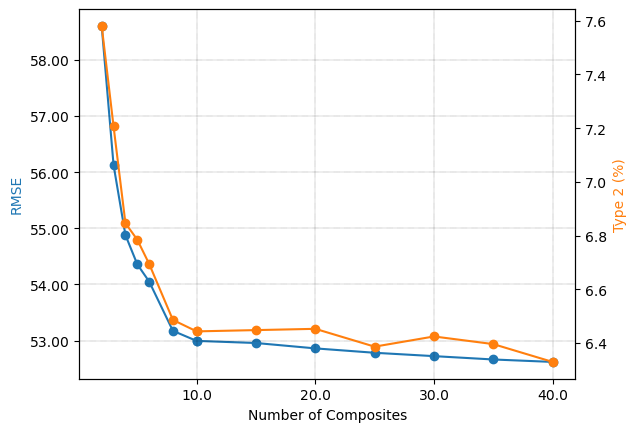

In [39]:
table = bh_calibrator.to_table("max_comps", ['rmse', 'sor', 'type12'], format_table=False)
fig, ax = plt.subplots()
_ = ax.plot(table['max_comps'], table['RMSE'], 'o-')
rmsp.format_plot(ax, 'Number of Composites', 'RMSE', grid=True)
ax.yaxis.label.set_color('C0')

ax1 = ax.twinx()
_ = ax1.plot(table['max_comps'], table['Type 2 (%)'], 'o-', color='C1')
ax1.set_ylabel('Type 2 (%)')
ax1.yaxis.label.set_color('C1')

## Gridded estimation using optimal estimator

Grab the optimal estimator and note that it's search corresponds with the highlighted results above:

In [40]:
estimator = bh_calibrator.get_estimator()
estimator.search

Search Parameters:
Angle 1     147.5
Angle 2      13.2
Angle 3     -21.3
Range 1     501.8
Range 2     140.2
Range 3     135.3
Min. Comps     40
Max. Comps     40

Estimate across the grid:

In [41]:
fin_grid['estimate'] = estimator.estimate(fin_grid, dh, var.col)

Visualize the results, noting the absence of search artifacts that were seen in the interim estimate:

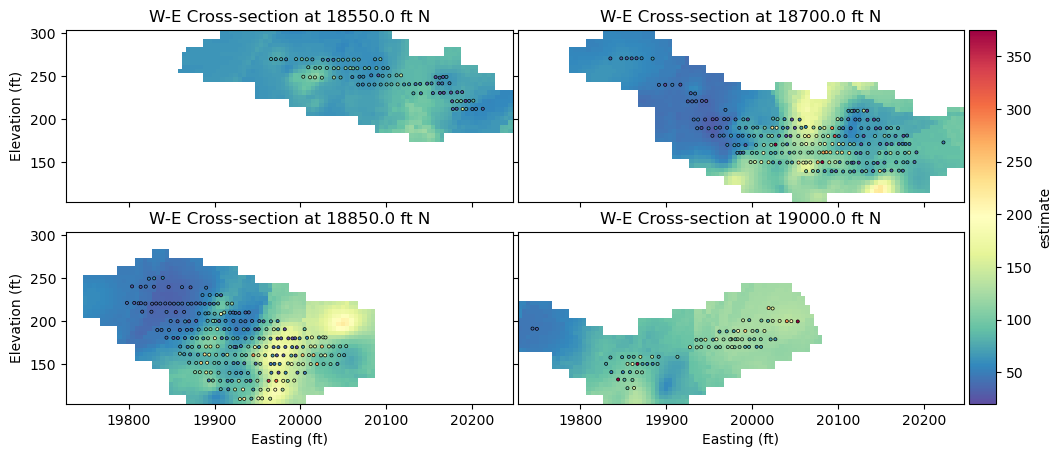

In [42]:
fig, axes = fin_grid.sectionplots('estimate', **scene, figsize=(12, 12))
_ = bh.sectionplots_draw(axes, var.col, **scene, tolerances=2.5, s=5, ec='k')